In [1]:
import tensorflow as tf
from tensorflow.python.keras.engine.base_layer import Layer
from math import sqrt
import math
import numpy as np
from tensorflow.keras.layers import LeakyReLU
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from tensorflow import keras
from tensorflow.keras import layers
from Energy_Models import Models as mo
from Data import preprocess_data as pr

In [2]:
df = pd.read_csv('D:\College\Final\Gpr\Datasets\household_power_consumption.txt',sep=';', 
                 parse_dates={'date_time' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='date_time')

In [3]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
date_time,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [5]:
df.shape

(2075259, 7)

In [6]:
df.isna().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [7]:
# filling missing values by the value of one day before 
def fill_missing(data):
    one_day = 24*60
    for row in range(data.shape[0]):
        for col in range(data.shape[1]):
            if np.isnan(data[row,col]):
                data[row,col] = data[row-one_day,col]

In [8]:
fill_missing(df.values)

In [9]:
df.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [10]:
# Compute remaining active power
df['sub_metering_remaining'] = (df.Global_active_power * 1000  / 60 ) - (df.Sub_metering_1 + df.Sub_metering_2 + df.Sub_metering_3)

In [11]:
# descriptive statistics
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_remaining
count,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,1.089418e+00,1.236871e-01,2.408364e+02,4.618401e+00,1.118474e+00,1.291131e+00,6.448635e+00,9.298722e+00
std,1.054678e+00,1.125933e-01,3.240051e+00,4.433165e+00,6.141460e+00,5.796922e+00,8.433584e+00,9.561278e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-2.400000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.800000e+00
50%,6.020000e-01,1.000000e-01,2.410000e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00,5.500000e+00
75%,1.526000e+00,1.940000e-01,2.428700e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01,1.036667e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01,1.248333e+02


In [12]:
# resample the data on daily basis
df = df.resample('D').mean()
df.shape

(1442, 8)

In [13]:
def train_test_split(df):
    
    # compute split point
    end_idx = df.shape[0]* 70 // 100
    
    train_data = df.iloc[:end_idx, : ]
    test_data = df.iloc[end_idx:, :]
    
    return train_data, test_data

In [14]:
# Split the data into train and test
X_train, X_test = train_test_split(df)

In [15]:
from sklearn.preprocessing import MinMaxScaler
def scale_data(train, test):
    scaler = MinMaxScaler().fit(train)
    return scaler.transform(train), scaler.transform(test), scaler

In [16]:
# Scale the data
X_train, X_test, scaler = scale_data(X_train, X_test)

In [17]:
# Split the training data into input features and out feature
X_train, Y_train = pr.convert_UNI_to_supervised(X_train)
print('Shape of (training data) input features : %s and ouput feature %s' % (X_train.shape, Y_train.shape))

Shape of (training data) input features : (1008, 1, 7) and ouput feature (1008,)


In [18]:
# Split the testing data into input features and out feature
X_test, Y_test = pr.convert_UNI_to_supervised(X_test)
print('Shape of (testing data) input features : %s and ouput feature %s' % (X_test.shape, Y_test.shape))

Shape of (testing data) input features : (432, 1, 7) and ouput feature (432,)


In [19]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [20]:
n_steps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], 1
model=mo.CNN(n_steps,n_features,n_outputs).getModel()
model.compile(optimizer='adam', loss ='mae')
history = model.fit(X_train , Y_train, epochs=100, batch_size=128, verbose= 1,validation_split=0.2,callbacks=callback)

Epoch 1/100
7/7 [==============================] - 1s 27ms/step - loss: 0.2656 - val_loss: 0.1286
Epoch 2/100
7/7 [==============================] - 0s 5ms/step - loss: 0.1561 - val_loss: 0.0908
Epoch 3/100
7/7 [==============================] - 0s 6ms/step - loss: 0.1195 - val_loss: 0.1260
Epoch 4/100
7/7 [==============================] - 0s 6ms/step - loss: 0.1121 - val_loss: 0.0787
Epoch 5/100
7/7 [==============================] - 0s 5ms/step - loss: 0.1093 - val_loss: 0.0738
Epoch 6/100
7/7 [==============================] - 0s 6ms/step - loss: 0.1053 - val_loss: 0.0814
Epoch 7/100
7/7 [==============================] - 0s 6ms/step - loss: 0.1017 - val_loss: 0.0765
Epoch 8/100
7/7 [==============================] - 0s 6ms/step - loss: 0.0999 - val_loss: 0.0707
Epoch 9/100
7/7 [==============================] - 0s 6ms/step - loss: 0.0960 - val_loss: 0.0598
Epoch 10/100
7/7 [==============================] - 0s 6ms/step - loss: 0.0946 - val_loss: 0.0602
Epoch 11/100
7/7 [==========

In [21]:
mo.evaluate(model,X_train, Y_train)
mo.evaluate(model,X_test, Y_test)

32/32 [==============================] - 0s 1ms/step - loss: 0.0729
evaluation : 0.073 
14/14 [==============================] - 0s 997us/step - loss: 0.0593
evaluation : 0.059 


In [22]:
y_pred_train = model.predict(X_train)
y_pred_test  = model.predict(X_test) 

14/14 [==============================] - 0s 997us/step


In [23]:
mo.print_metrics(model,Y_train,y_pred_train,Y_test,y_pred_test)

Train RMSE value   : 0.103 
Train MSE value    : 0.011 
Train R2 value     : 0.470 
Train MAPE value   : 9029446054.916 
Train RMLSE value  : 0.006 
Train MAE value    : 0.073 
---------------------------------------------
Test RMSE value   : 0.080 
Test MSE value   : 0.006 
Test R2 value   : 0.416 
Test MAPE value  : 0.221 
Test RMLSE value  : 0.004 
Test MAE value : 0.059 


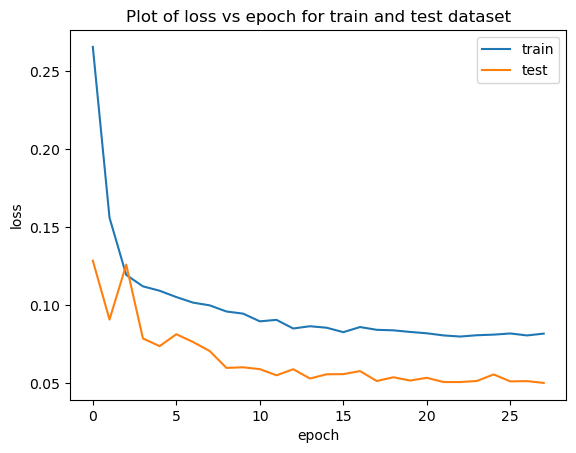

In [24]:
import matplotlib.pyplot as plt 
# Plot of loss vs epoch for train and test dataset
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Plot of loss vs epoch for train and test dataset")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [25]:
# Split the data into train and test
X_train, X_test = train_test_split(df)

In [26]:
# Scale the data
X_train, X_test, scaler = scale_data(X_train, X_test)

In [27]:
# Split the training data into input features and out feature
X_train, Y_train = pr.convert_Multi_to_supervised(X_train)
print('Shape of (training data) input features : %s and ouput feature %s' % (X_train.shape, Y_train.shape))

Shape of (training data) input features : (982, 21, 7) and ouput feature (982, 7)


In [28]:
X_test, Y_test = pr.convert_Multi_to_supervised(X_test)
print('Shape of (testing data) input features : %s and ouput feature %s' % (X_test.shape, Y_test.shape))

Shape of (testing data) input features : (406, 21, 7) and ouput feature (406, 7)


In [29]:
n_steps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], Y_train.shape[1]
model = mo.CNN(n_steps,n_features,n_outputs).getModel()
model.compile(optimizer='adam', loss ='mse')
history = model.fit(X_train , Y_train, epochs=200, batch_size=256, verbose= 1,validation_split=0.2,callbacks=callback)

Epoch 1/200
4/4 [==============================] - 1s 52ms/step - loss: 0.0933 - val_loss: 0.0265
Epoch 2/200
4/4 [==============================] - 0s 16ms/step - loss: 0.0455 - val_loss: 0.0162
Epoch 3/200
4/4 [==============================] - 0s 15ms/step - loss: 0.0306 - val_loss: 0.0100
Epoch 4/200
4/4 [==============================] - 0s 21ms/step - loss: 0.0272 - val_loss: 0.0093
Epoch 5/200
4/4 [==============================] - 0s 17ms/step - loss: 0.0228 - val_loss: 0.0070
Epoch 6/200
4/4 [==============================] - 0s 16ms/step - loss: 0.0203 - val_loss: 0.0057
Epoch 7/200
4/4 [==============================] - 0s 19ms/step - loss: 0.0195 - val_loss: 0.0060
Epoch 8/200
4/4 [==============================] - 0s 15ms/step - loss: 0.0182 - val_loss: 0.0050
Epoch 9/200
4/4 [==============================] - 0s 18ms/step - loss: 0.0181 - val_loss: 0.0048
Epoch 10/200
4/4 [==============================] - 0s 17ms/step - loss: 0.0175 - val_loss: 0.0047
Epoch 11/200
4/4 [=

In [30]:
mo.evaluate(model,X_train, Y_train)
mo.evaluate(model,X_test, Y_test)

31/31 [==============================] - 0s 2ms/step - loss: 0.0105
evaluation : 0.011 
13/13 [==============================] - 0s 1ms/step - loss: 0.0068
evaluation : 0.007 


In [31]:
y_pred_train = model.predict(X_train)
y_pred_test  = model.predict(X_test) 

13/13 [==============================] - 0s 1ms/step


In [32]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error, mean_absolute_percentage_error
def root_mean_squared_error(y_true, y_pred):    
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [33]:
def print_metrics(model,Y_train,Y_pred_train,Y_test,Y_pred_test):
    print('Train MAE  value   : %.3f ' % mean_absolute_error(Y_train, Y_pred_train))
    print('Train MSE  value   : %.3f ' % mean_squared_error(Y_train, Y_pred_train))
    print('Train RMSE value   : %.3f ' % root_mean_squared_error(Y_train, Y_pred_train))
    print('Train R2   value   : %.3f ' % r2_score(Y_train, Y_pred_train))
    print('---------------------------------------------')
    print('Test  MAE  value   : %.3f ' % mean_absolute_error(Y_test, Y_pred_test))
    print('Test  MSE  value   : %.3f ' % mean_squared_error(Y_test, Y_pred_test))
    print('Test  RMSE value   : %.3f ' % root_mean_squared_error(Y_test, Y_pred_test))
    print('Test  R2   value   : %.3f ' % r2_score(Y_test, Y_pred_test))
print_metrics(model,Y_train,y_pred_train,Y_test,y_pred_test)

Train MAE  value   : 0.077 
Train MSE  value   : 0.011 
Train RMSE value   : 0.103 
Train R2   value   : 0.438 
---------------------------------------------
Test  MAE  value   : 0.062 
Test  MSE  value   : 0.007 
Test  RMSE value   : 0.083 
Test  R2   value   : 0.405 


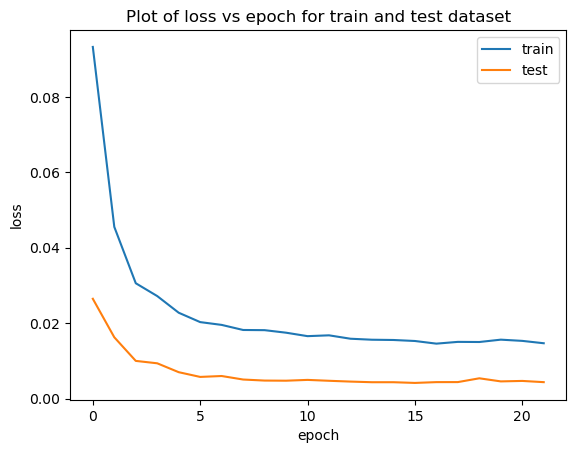

In [34]:
# Plot of loss vs epoch for train and test dataset
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Plot of loss vs epoch for train and test dataset")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()